In [36]:
import numpy as np
import matplotlib.pyplot as plt
import energyflow as ef
import energyflow.archs
from energyflow.archs import PFN
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Layer, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization

plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"


In [37]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [38]:
#These are the same datasets from the OmniFold paper https://arxiv.org/abs/1911.09107.  More detail at https://energyflow.network/docs/datasets/.
#Pythia and Herwig are two generators; one will be treated here as the "simulation" and one as "data".
datasets = {'Pythia26': ef.zjets_delphes.load('Pythia26', num_data=1000000),
            'Herwig': ef.zjets_delphes.load('Herwig', num_data=1000000)}

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Set up the observables

In [4]:
def is_charged(myin):
    if (myin == 0):
        return 0
    elif (myin == 0.1):
        return 1
    elif (myin == 0.2):
        return -1
    elif (myin == 0.3):
        return 0
    elif (myin == 0.4):
        return -1
    elif (myin == 0.5):
        return 1
    elif (myin == 0.6):
        return -1
    elif (myin == 0.7):
        return 1
    elif (myin == 0.8):
        return 1
    elif (myin == 0.9):
        return -1
    elif (myin == 1.0):
        return 1
    elif (myin == 1.1):
        return -1
    elif (myin == 1.2):
        return 0
    elif (myin == 1.3):
        return 0

$$mycharges = \frac{\sum Q \sqrt{p_T}}{\sum\sqrt{p_T}}$$


$$mycharges2 = \frac{\sum Q\; p_T}{\sum p_T}$$

In [ ]:


for dataset in datasets:
    mycharges = []
    mycharges2 = []
    for i in range(len(datasets[dataset]['gen_particles'])):
        pTs = datasets[dataset]['gen_particles'][i][:,0]
        charges = [is_charged(datasets[dataset]['gen_particles'][i][:,3][j]) for j in range(len(datasets[dataset]['gen_particles'][i][:,3]))]
        mycharges+=[np.sum(charges*pTs**0.5)/np.sum(pTs**0.5)]
        mycharges2+=[np.sum(np.abs(charges)*pTs)/np.sum(pTs)]
    datasets[dataset]['gen_charge'] = mycharges
    datasets[dataset]['gen_pTcharge'] = mycharges2

    mycharges = []
    mycharges2 = []
    for i in range(len(datasets[dataset]['sim_particles'])):
        pTs = datasets[dataset]['sim_particles'][i][:,0]
        charges = [is_charged(datasets[dataset]['sim_particles'][i][:,3][j]) for j in range(len(datasets[dataset]['sim_particles'][i][:,3]))]
        mycharges+=[np.sum(charges*pTs**0.5)/np.sum(pTs**0.5)]
        mycharges2+=[np.sum(np.abs(charges)*pTs)/np.sum(pTs)]
    datasets[dataset]['sim_charge'] = mycharges
    datasets[dataset]['sim_pTcharge'] = mycharges2

In [ ]:
datasets['Pythia26'].keys()

In [ ]:
tau2s_Pythia_sim = datasets['Pythia26']['sim_tau2s']
tau2s_Herwig_sim = datasets['Herwig']['sim_tau2s']

tau1s_Pythia_sim = datasets['Pythia26']['sim_widths']
tau1s_Herwig_sim = datasets['Herwig']['sim_widths']

tau2s_Pythia_gen = datasets['Pythia26']['gen_tau2s']
tau2s_Herwig_gen = datasets['Herwig']['gen_tau2s']

tau1s_Pythia_gen = datasets['Pythia26']['gen_widths']
tau1s_Herwig_gen = datasets['Herwig']['gen_widths']

In [39]:
#
w_true = datasets['Pythia26']['gen_widths']
w_reco = datasets['Pythia26']['sim_widths']
w_true_alt = datasets['Herwig']['gen_widths']
w_reco_alt = datasets['Herwig']['sim_widths']

In [ ]:
print(f'{w_true = })

In [5]:
pT_true = datasets['Pythia26']['gen_jets'][:,0]
m_true = datasets['Pythia26']['gen_jets'][:,3]
pT_reco = datasets['Pythia26']['sim_jets'][:,0]
m_reco = datasets['Pythia26']['sim_jets'][:,3]

pT_true_alt = datasets['Herwig']['gen_jets'][:,0]
m_true_alt = datasets['Herwig']['gen_jets'][:,3]
pT_reco_alt = datasets['Herwig']['sim_jets'][:,0]
m_reco_alt = datasets['Herwig']['sim_jets'][:,3]


#
q_true = np.array(datasets['Pythia26']['gen_charge'])
q_reco = np.array(datasets['Pythia26']['sim_charge'])
q_true_alt = np.array(datasets['Herwig']['gen_charge'])
q_reco_alt = np.array(datasets['Herwig']['sim_charge'])

#
r_true = np.array(datasets['Pythia26']['gen_pTcharge'])
r_reco = np.array(datasets['Pythia26']['sim_pTcharge'])
r_true_alt = np.array(datasets['Herwig']['gen_pTcharge'])
r_reco_alt = np.array(datasets['Herwig']['sim_pTcharge'])

KeyError: 'gen_charge'

In [ ]:
plt.hist(r_true,bins=np.linspace(0,1.5,20))
plt.axvline(2/3, color="black",ls=":")
plt.show()

## Moment OmniFolding

In [10]:
gauss_data = np.random.normal(0,1,100000)
gauss_sim = np.random.normal(-0.5,1,100000)

In [40]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    return K.mean(t_loss)

In [ ]:
losses = []
for lambda1 in np.linspace(-1,1,20):

    xvals_1 = np.concatenate([gauss_data,gauss_sim])
    yvals_1 = np.concatenate([np.ones(len(gauss_data)),np.zeros(len(gauss_sim))])
    weights_1 = np.concatenate([np.ones(len(gauss_data)),np.exp(lambda1*gauss_sim)*len(gauss_data)/np.sum(np.exp(lambda1*gauss_sim))])

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

    Y_train_2 = np.stack((Y_train_1, w_train_1), axis=1)
    Y_test_2 = np.stack((Y_test_1, w_test_1), axis=1)

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss=weighted_binary_crossentropy, optimizer='Adam', metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_2,
              epochs=10,
              batch_size=1000,
              verbose=0)
    losses+=[model.history.history['loss'][-1]]

In [ ]:
#plots with hand inserted lambda
lambda1 = 0.5

xvals_1 = np.concatenate([gauss_data,gauss_sim])
yvals_1 = np.concatenate([np.ones(len(gauss_data)),np.zeros(len(gauss_sim))])
weights_1 = np.concatenate([np.ones(len(gauss_data)),np.exp(lambda1*gauss_sim)*len(gauss_data)/np.sum(np.exp(lambda1*gauss_sim))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

fig, ax = plt.subplots(figsize=(10, 7))

# ax.xaxis.label.set_color('white')        #setting up X-axis label color to yellow
# ax.yaxis.label.set_color('white')          #setting up Y-axis label color to blue

# ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
# ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black

# ax.spines['left'].set_color('white')        # setting up Y-axis tick color to red
# ax.spines['top'].set_color('white')
# ax.spines['right'].set_color('white') 
# ax.spines['bottom'].set_color('white') 
_,_,_=plt.hist(X_test_1[Y_test_1==1],bins=np.linspace(-4,4,20),alpha=0.5,label="data")
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=np.linspace(-4,4,20),alpha=0.5,label="MC")
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=np.linspace(-4,4,20),weights=w_test_1[Y_test_1==0],histtype="step",color="r",ls=":", lw=4,label="weighted MC")
plt.legend(fontsize=15)
plt.ylim([0,5000])
plt.xlabel("x")
plt.ylabel("Trials")
plt.savefig("gaussexample.pdf", bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

# ax.xaxis.label.set_color('white')        #setting up X-axis label color to yellow
# ax.yaxis.label.set_color('white')          #setting up Y-axis label color to blue

# ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
# ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black

# ax.spines['left'].set_color('white')        # setting up Y-axis tick color to red
# ax.spines['top'].set_color('white')
# ax.spines['right'].set_color('white') 
# ax.spines['bottom'].set_color('white') 
plt.plot(np.linspace(-1,1,20),losses, lw=4)
plt.axvline(1/2, color="r",ls=":", lw=4)
plt.ylabel("Loss")
plt.xlabel(r"$\mu$")
plt.savefig("gaussloss.pdf", bbox_inches='tight',  transparent=True)

plt.show()

In [41]:
#scan over lambda_1

losses_width = []
n = 0
for lambda1 in np.linspace(-2,10,20):

    xvals_1 = np.concatenate([w_true_alt,w_true])
    yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])
    weights_1 = np.concatenate([np.ones(len(w_true_alt)),np.exp(lambda1*w_true)*len(w_true_alt)/np.sum(np.exp(lambda1*w_true))])

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

    Y_train_2 = np.stack((Y_train_1, w_train_1), axis=1)
    Y_test_2 = np.stack((Y_test_1, w_test_1), axis=1)

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss=weighted_binary_crossentropy, optimizer='Adam', metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_2,
              epochs=3,
              batch_size=1000,
              verbose=0)
    print(n)
    n+=1
    losses_width+=[model.history.history['loss'][-1]]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [42]:
#larger width

losses_width2 = []
n = 1
for lambda1 in np.linspace(-2,10,20):
    print(n)
    n += 1
    xvals_1 = np.concatenate([w_true_alt,w_true])
    yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])
    weights_1 = np.concatenate([np.ones(len(w_true_alt)),np.exp(lambda1*w_true**2)*len(w_true_alt)/np.sum(np.exp(lambda1*w_true**2))])

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

    Y_train_2 = np.stack((Y_train_1, w_train_1), axis=1)
    Y_test_2 = np.stack((Y_test_1, w_test_1), axis=1)

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss=weighted_binary_crossentropy, optimizer='Adam', metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_2,
              epochs=3,
              batch_size=1000,
              verbose=0)
    losses_width2+=[model.history.history['loss'][-1]]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


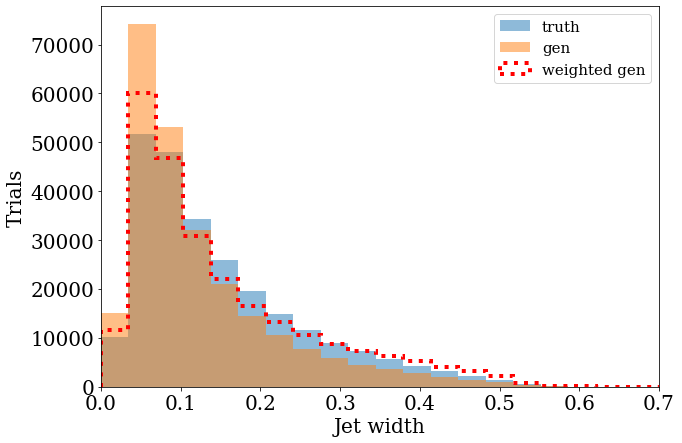

In [45]:
lambda1 = 2.5
#black is as close as possible (KL) to the orange but has the same mean as the blue
xvals_1 = np.concatenate([w_true_alt,w_true])
yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])
weights_1 = np.concatenate([np.ones(len(w_true_alt)),np.exp(lambda1*w_true)*len(w_true_alt)/np.sum(np.exp(lambda1*w_true))])

fig, ax = plt.subplots(figsize=(10, 7))
# ax.xaxis.label.set_color('white')        #setting up X-axis label color to yellow
# ax.yaxis.label.set_color('white')          #setting up Y-axis label color to blue

# ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
# ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black

# ax.spines['left'].set_color('white')        # setting up Y-axis tick color to red
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_color('white') 

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

_,_,_=plt.hist(X_test_1[Y_test_1==1],bins=np.linspace(0,1,30),alpha=0.5,label="truth")
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=np.linspace(0,1,30),alpha=0.5,label="gen")
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=np.linspace(0,1,30),weights=w_test_1[Y_test_1==0],histtype="step",color="r",ls=":", lw=4,label="weighted gen")
plt.legend(fontsize=15)
plt.xlabel("Jet width")
plt.ylabel("Trials")
plt.xlim(0, 0.7)
plt.savefig("jetexample.pdf", bbox_inches='tight', transparent=True)

In [7]:
for lambda1 in np.linspace(-1,10,20):

    xvals_1 = np.concatenate([w_true_alt,w_true])
    yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])
    weights_1 = np.concatenate([np.ones(len(w_true_alt)),np.exp(lambda1*w_true)*len(w_true_alt)/np.sum(np.exp(lambda1*w_true))])

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

    print(lambda1,np.mean(X_test_1[Y_test_1==1]),np.mean(X_test_1[Y_test_1==0]),np.average(X_test_1[Y_test_1==0],weights=w_test_1[Y_test_1==0]))

-1.0 0.1499150224394371 0.12287125553825515 0.11451745095384766
-0.42105263157894735 0.14994936895504266 0.1229856940160692 0.11930357792006249
0.1578947368421053 0.14984681530935287 0.12287355461678254 0.1243186142165097
0.736842105263158 0.14995989520833006 0.12268385935218337 0.12970353465128628
1.3157894736842106 0.14990593677718142 0.12260799836066104 0.1356816554706811
1.8947368421052633 0.1496912387140729 0.1227781561746979 0.14268039255360984
2.473684210526316 0.14993472685451864 0.12305719441491611 0.15035824276618853
3.052631578947368 0.14987107283536588 0.1231096771583376 0.1583390360178079
3.6315789473684212 0.14949400611448663 0.12264150919952237 0.1665618742431424
4.210526315789474 0.15002349331008882 0.12296458418067352 0.17596693080347872
4.7894736842105265 0.14990591023404584 0.1230491448714787 0.18654473578980393
5.368421052631579 0.1497716441618195 0.12287768702466398 0.19634102190154681
5.947368421052632 0.14976878263274826 0.12271181751800274 0.20742137956265028
6.

In [12]:
for lambda1 in np.linspace(-1,10,20):

    xvals_1 = np.concatenate([w_true_alt,w_true])
    yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])
    weights_1 = np.concatenate([np.ones(len(w_true_alt)),np.exp(lambda1*w_true**2)*len(w_true_alt)/np.sum(np.exp(lambda1*w_true**2))])

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

    print(lambda1,np.mean(X_test_1[Y_test_1==1]**2),np.mean(X_test_1[Y_test_1==0]**2),np.average(X_test_1[Y_test_1==0]**2,weights=w_test_1[Y_test_1==0]))

-1.0 0.033618750134091 0.02409695031976676 0.02257562301873861
-0.42105263157894735 0.03377255565275985 0.02399036544828064 0.023332891231633675
0.1578947368421053 0.033647260668984234 0.024014271522913917 0.02427183133871478
0.736842105263158 0.03373906441726578 0.024196013004223606 0.02545205589428857
1.3157894736842106 0.03362510378451358 0.024169159877748935 0.026484248123527853
1.8947368421052633 0.033755836327689206 0.024133107699210486 0.027620958640023004
2.473684210526316 0.03368998909810467 0.024079161253666232 0.02873761969184608
3.052631578947368 0.033767730395515595 0.024100677817915875 0.030115037583862126
3.6315789473684212 0.0336366038164249 0.0240914726777095 0.03156405853121285
4.210526315789474 0.03366053478241145 0.024046316820325774 0.03307579781481924
4.7894736842105265 0.03386911241521149 0.024070916469094934 0.03473144853773282
5.368421052631579 0.033731845101583176 0.0240482733689934 0.03665133572738789
5.947368421052632 0.033611847352118446 0.02408796146134558

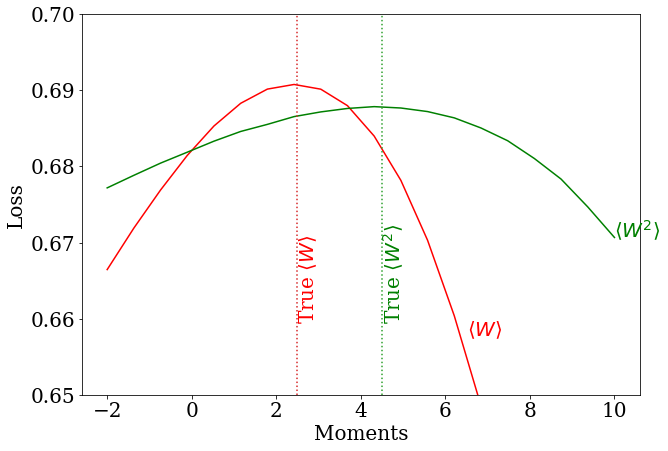

In [46]:
c = 'black'
fig, ax = plt.subplots(figsize=(10, 7))
ax.xaxis.label.set_color(c)        #setting up X-axis label color to yellow
ax.yaxis.label.set_color(c)          #setting up Y-axis label color to blue

ax.tick_params(axis='x', colors=c)    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors=c)  #setting up Y-axis tick color to black

ax.spines['left'].set_color(c)        # setting up Y-axis tick color to red
ax.spines['top'].set_color(c)
ax.spines['right'].set_color(c) 
ax.spines['bottom'].set_color(c) 


losses_width = np.array(losses_width)
losses_width2 = np.array(losses_width2)
plt.plot(np.linspace(-2,10,20),losses_width, color='r')
plt.text(np.linspace(-2,10,20)[-1]-3.5,losses_width[-1]+0.1, r'$\langle W\rangle$', color='r')
plt.plot(np.linspace(-2,10,20),losses_width2, color='green')
plt.text(np.linspace(-2,10,20)[-1],losses_width2[-1], r'$\langle W^2\rangle$', color='green')
plt.axvline(2.5,color="tab:red",ls=":")
plt.axvline(4.5,color="tab:green",ls=":")
plt.ylim([0.65,0.7])
plt.ylabel("Loss")
plt.xlabel("Moments")
plt.text(2.5,0.66,r'True $\langle W\rangle$',rotation=90, color='r')
plt.text(4.5,0.66,r'True $\langle W^2\rangle$',rotation=90, color='g')

plt.savefig("jetloss.pdf", bbox_inches='tight', transparent=True)

In [47]:
truth = X_test_1[Y_test_1==1]
gen = X_test_1[Y_test_1==0]
weights = w_test_1[Y_test_1==0]

np.savez('finite_jet_width.npz', losses1=losses_width, losses2= losses_width2, truth=truth, gen=gen, weights=weights)

In [50]:
#run this cell directly to load data
npzfile = np.load('finite_jet_width.npz')
losses_width=npzfile['losses1']
losses_width2=npzfile['losses2']

truth=npzfile['truth']
gen=npzfile['gen']
weights=npzfile['weights']

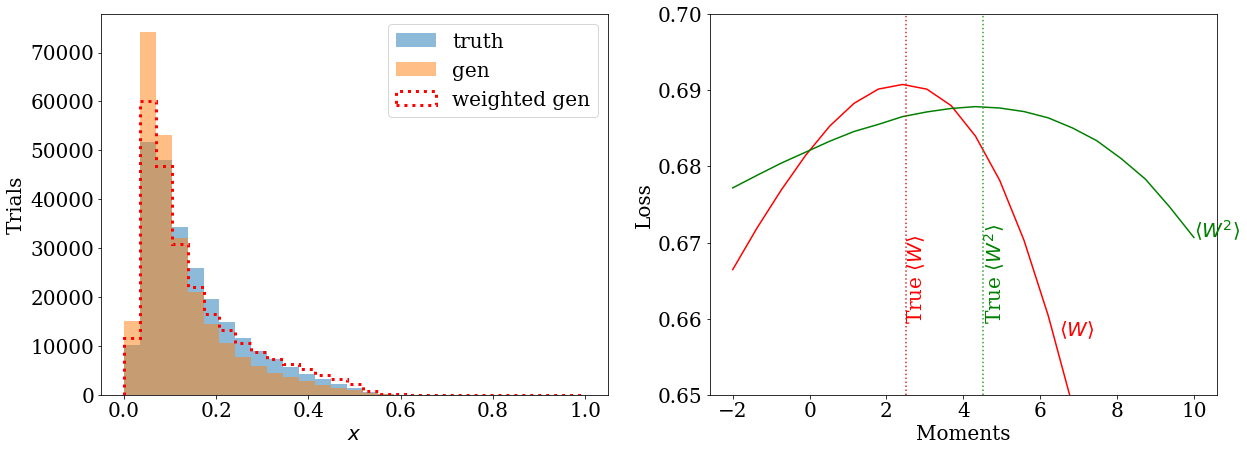

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

bins = np.linspace(0,1,30)
_,_,_=ax[0].hist(truth,alpha=0.5,label="truth", bins=bins)
_,_,_=ax[0].hist(gen,alpha=0.5,label="gen", bins=bins)
_,_,_=ax[0].hist(gen,weights=weights,histtype="step",color="r",ls=":", lw=3,label="weighted gen", bins=bins)
ax[0].legend()
ax[0].set_xlabel(r"$x$")
ax[0].set_ylabel("Trials")

plt.plot(np.linspace(-2,10,20),losses_width, color='r')
plt.text(np.linspace(-2,10,20)[-1]-3.5,losses_width[-1]+0.1, r'$\langle W\rangle$', color='r')
plt.plot(np.linspace(-2,10,20),losses_width2, color='green')
plt.text(np.linspace(-2,10,20)[-1],losses_width2[-1], r'$\langle W^2\rangle$', color='green')
plt.axvline(2.5,color="tab:red",ls=":")
plt.axvline(4.5,color="tab:green",ls=":")
plt.ylim([0.65,0.7])
plt.ylabel("Loss")
plt.xlabel("Moments")
plt.text(2.5,0.66,r'True $\langle W\rangle$',rotation=90, color='r')
plt.text(4.5,0.66,r'True $\langle W^2\rangle$',rotation=90, color='g')





plt.savefig("finite_jetwidth_combined.pdf", bbox_inches='tight', transparent=True)
plt.show()

## Try to do it in one step instead of scanning?

In [ ]:
initializer = tf.keras.initializers.RandomUniform(minval=-5., maxval=5.)

class MyLayer(Layer):

    def __init__(self, myc, **kwargs):
        self.myinit = myc
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._lambda0 = self.add_weight(name='lambda0', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self._lambda1 = self.add_weight(name='lambda1', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        #return tf.exp(self._lambda1 * x + self._lambda0)
        return tf.exp(self._lambda0 * x + self._lambda1 * x**2)

myc = 0.1
mymodel_inputtest = Input(shape=(1,))
mymodel_test = MyLayer(myc)(mymodel_inputtest)
model_generator = Model(mymodel_inputtest, mymodel_test)

inputs_disc = Input((1, ))
hidden_layer_1_disc = Dense(50, activation='relu')(inputs_disc)
hidden_layer_2_disc = Dense(50, activation='relu')(hidden_layer_1_disc)
hidden_layer_3_disc = Dense(50, activation='relu')(hidden_layer_2_disc)
outputs_disc = Dense(1, activation='sigmoid')(hidden_layer_3_disc)
model_discrimantor = Model(inputs=inputs_disc, outputs=outputs_disc)

def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred)/weights_1 +
                         (1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

model_discrimantor.compile(loss=weighted_binary_crossentropy, optimizer='adam')

def weighted_binary_crossentropy_GAN(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    #tf.print("weights",weights_0,weights_1)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = weights * ((1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)
    
model_discrimantor.trainable = False
mymodel_gan = Input(shape=(1,))
gan_model = Model(inputs=mymodel_gan,outputs=concatenate([model_discrimantor(mymodel_gan),model_generator(mymodel_gan)]))

gan_model.compile(loss=weighted_binary_crossentropy_GAN, optimizer='adam')

In [ ]:
#xvals_1 = np.concatenate([gauss_data,gauss_sim])
#yvals_1 = np.concatenate([np.ones(len(gauss_data)),np.zeros(len(gauss_sim))])

xvals_1 = np.concatenate([w_true_alt,w_true])
yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])

X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

n_epochs = 20
n_batch = 128*10
n_batches = len(X_train_1) // n_batch

for i in range(n_epochs):
    lambdasum = np.log(model_generator.predict([1.]))
    lambdasum2 = np.log(model_generator.predict([2.]))
    mylambda1 = (lambdasum2-2*lambdasum)/2
    mylambda0 = lambdasum - mylambda1
    print("on epoch=",i,mylambda0,mylambda1)
    #print("  ",np.sum(model_generator.predict(X_train_1,batch_size=1000)))
    for j in range(n_batches):
        X_batch = X_train_1[j*n_batch:(j+1)*n_batch]
        Y_batch = Y_train_1[j*n_batch:(j+1)*n_batch]
        W_batch = model_generator(X_batch)
        W_batch = np.array(W_batch).flatten()
        W_batch[Y_batch==1] = 1
        #W_batch[Y_batch==0] = 1
        
        Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)
        
        model_discrimantor.train_on_batch(X_batch, Y_batch_2)
        
        #print("      ",j,np.sum(model_generator.predict(X_batch,batch_size=1000)),np.log(model_generator.predict([1.]))-np.log(model_generator.predict([0.])),np.log(model_generator.predict([0.])))
        
        gan_model.train_on_batch(X_batch[Y_batch==0],np.zeros(len(X_batch[Y_batch==0])))

In [ ]:
lambda0 = 6.5
lambda1 = -9.3
xvals_1 = np.concatenate([w_true_alt,w_true])
yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])
weights_1 = np.concatenate([np.ones(len(w_true_alt)),np.exp(lambda1*w_true**2+lambda0*w_true)*len(w_true_alt)/np.sum(np.exp(lambda1*w_true**2+lambda0*w_true))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

print(np.mean(X_test_1[Y_test_1==1]**2),np.mean(X_test_1[Y_test_1==0]**2),np.average(X_test_1[Y_test_1==0]**2,weights=w_test_1[Y_test_1==0]))
print(np.mean(X_test_1[Y_test_1==1]),np.mean(X_test_1[Y_test_1==0]),np.average(X_test_1[Y_test_1==0],weights=w_test_1[Y_test_1==0]))

## 3 Moments

In [ ]:
initializer = tf.keras.initializers.RandomUniform(minval=-5., maxval=5.)

class MyLayer(Layer):

    def __init__(self, myc, **kwargs):
        self.myinit = myc
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._lambda0 = self.add_weight(name='lambda0', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self._lambda1 = self.add_weight(name='lambda1', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self._lambda2 = self.add_weight(name='lambda1', 
                            shape=(1,),
                            initializer=tf.keras.initializers.Constant(self.myinit), 
                            trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        #return tf.exp(self._lambda1 * x + self._lambda0)
        return tf.exp(self._lambda0 * x + self._lambda1 * x**2 + self._lambda2 * x**3)

myc = 0.1
mymodel_inputtest = Input(shape=(1,))
mymodel_test = MyLayer(myc)(mymodel_inputtest)
model_generator = Model(mymodel_inputtest, mymodel_test)

inputs_disc = Input((1, ))
hidden_layer_1_disc = Dense(50, activation='relu')(inputs_disc)
hidden_layer_2_disc = Dense(50, activation='relu')(hidden_layer_1_disc)
hidden_layer_3_disc = Dense(50, activation='relu')(hidden_layer_2_disc)
outputs_disc = Dense(1, activation='sigmoid')(hidden_layer_3_disc)
model_discrimantor = Model(inputs=inputs_disc, outputs=outputs_disc)

def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred)/weights_1 +
                         (1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

model_discrimantor.compile(loss=weighted_binary_crossentropy, optimizer='adam')

def weighted_binary_crossentropy_GAN(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    #tf.print("weights",weights_0,weights_1)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = weights * ((1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)
    
model_discrimantor.trainable = False
mymodel_gan = Input(shape=(1,))
gan_model = Model(inputs=mymodel_gan,outputs=concatenate([model_discrimantor(mymodel_gan),model_generator(mymodel_gan)]))

gan_model.compile(loss=weighted_binary_crossentropy_GAN, optimizer='adam')

In [ ]:
#xvals_1 = np.concatenate([gauss_data,gauss_sim])
#yvals_1 = np.concatenate([np.ones(len(gauss_data)),np.zeros(len(gauss_sim))])

xvals_1 = np.concatenate([w_true_alt,w_true])
yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])

X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

n_epochs = 20
n_batch = 128*10
n_batches = len(X_train_1) // n_batch

for i in range(n_epochs):
    A = np.log(model_generator.predict([1.]))
    B = np.log(model_generator.predict([2.]))
    C = np.log(model_generator.predict([-1.]))
    mylambda0 = A - B/3 - C/3
    mylambda1 = (A + C)/2
    mylambda2 = (-3*A + 2*B - C)/6
    print("on epoch=",i,mylambda0,mylambda1, mylambda2)
    #print("  ",np.sum(model_generator.predict(X_train_1,batch_size=1000)))
    for j in range(n_batches):
        X_batch = X_train_1[j*n_batch:(j+1)*n_batch]
        Y_batch = Y_train_1[j*n_batch:(j+1)*n_batch]
        W_batch = model_generator(X_batch)
        W_batch = np.array(W_batch).flatten()
        W_batch[Y_batch==1] = 1
        #W_batch[Y_batch==0] = 1
        
        Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)
        
        model_discrimantor.train_on_batch(X_batch, Y_batch_2)
        
        #print("      ",j,np.sum(model_generator.predict(X_batch,batch_size=1000)),np.log(model_generator.predict([1.]))-np.log(model_generator.predict([0.])),np.log(model_generator.predict([0.])))
        
        gan_model.train_on_batch(X_batch[Y_batch==0],np.zeros(len(X_batch[Y_batch==0])))

In [ ]:
lambda0, lambda1, lambda2 = model_generator.layers[-1].get_weights()
xvals_1 = np.concatenate([w_true_alt,w_true])
yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])
weights_1 = np.concatenate([np.ones(len(w_true_alt)),np.exp(lambda2*w_true**3+lambda1*w_true**2+lambda0*w_true)*len(w_true_alt)/np.sum(np.exp(lambda1*w_true**2+lambda0*w_true))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

#data, simulation w/o weights, weighted simulation
print(np.mean(X_test_1[Y_test_1==1]**2),np.mean(X_test_1[Y_test_1==0]**2),np.average(X_test_1[Y_test_1==0]**2,weights=w_test_1[Y_test_1==0]))
#
print(np.mean(X_test_1[Y_test_1==1]),np.mean(X_test_1[Y_test_1==0]),np.average(X_test_1[Y_test_1==0],weights=w_test_1[Y_test_1==0]))

print(np.mean(X_test_1[Y_test_1==1]**3),np.mean(X_test_1[Y_test_1==0]**3),np.average(X_test_1[Y_test_1==0]**3,weights=w_test_1[Y_test_1==0]))

In [ ]:
model_generator.layers[-1].get_weights()

## Now unfold all at once

In [ ]:
#mymodel_inputtest_unifold = Input(shape=(1,))
#hidden_layer_1_unifold = Dense(50, activation='LeakyReLU',use_bias=False)(mymodel_inputtest_unifold)
#batch_norm_1_unifold = BatchNormalization()(hidden_layer_1_unifold)
#hidden_layer_2_unifold = Dense(50, activation='LeakyReLU',use_bias=False)(batch_norm_1_unifold)
#batch_norm_2_unifold = BatchNormalization()(hidden_layer_2_unifold)
#hidden_layer_3_unifold = Dense(50, activation='LeakyReLU',use_bias=False)(batch_norm_2_unifold)
#outputs_unifold = Dense(1, activation='sigmoid',use_bias=False)(hidden_layer_3_unifold) #tanh
#model_generator_unifold = Model(mymodel_inputtest_unifold, outputs_unifold) #tf.exp(10*outputs_unifold))

mymodel_inputtest_unifold = Input(shape=(1,))
hidden_layer_1_unifold = Dense(50, activation='ReLU',use_bias=True)(mymodel_inputtest_unifold)
batch_norm_1_unifold = BatchNormalization()(hidden_layer_1_unifold)
hidden_layer_2_unifold = Dense(50, activation='ReLU',use_bias=True)(batch_norm_1_unifold)
batch_norm_2_unifold = BatchNormalization()(hidden_layer_2_unifold)
hidden_layer_3_unifold = Dense(50, activation='ReLU',use_bias=True)(batch_norm_2_unifold)
outputs_unifold = Dense(1, activation='sigmoid',use_bias=True)(hidden_layer_3_unifold) #tanh
model_generator_unifold = Model(mymodel_inputtest_unifold, outputs_unifold)

inputs_disc_unifold = Input((1, ))
hidden_layer_1_disc_unifold = Dense(50, activation='LeakyReLU')(inputs_disc_unifold)
batch_norm_1_disc_unifold = BatchNormalization()(hidden_layer_1_disc_unifold)
hidden_layer_2_disc_unifold = Dense(50, activation='LeakyReLU')(batch_norm_1_disc_unifold)
batch_norm_2_disc_unifold = BatchNormalization()(hidden_layer_2_disc_unifold)
hidden_layer_3_disc_unifold = Dense(50, activation='LeakyReLU')(batch_norm_2_disc_unifold)
outputs_disc_unifold = Dense(1, activation='sigmoid')(hidden_layer_3_disc_unifold)
model_discrimantor_unifold = Model(inputs=inputs_disc_unifold, outputs=outputs_disc_unifold)

opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
#opt2 = tf.keras.optimizers.Adam(learning_rate=1e-4)

model_discrimantor_unifold.compile(loss=weighted_binary_crossentropy, optimizer=opt)
    
model_discrimantor_unifold.trainable = False
mymodel_gan_unifold = Input(shape=(1,))
gan_model_unifold = Model(inputs=mymodel_gan_unifold,outputs=concatenate([model_discrimantor_unifold(mymodel_gan_unifold),model_generator_unifold(mymodel_gan_unifold)]))

gan_model_unifold.compile(loss=weighted_binary_crossentropy_GAN, optimizer=opt)

In [ ]:
xvals_1 = np.concatenate([w_true_alt,w_true])
yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])

#xvals_1 = np.concatenate([w_true_alt,w_true])
#yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])

X_std = (xvals_1 - xvals_1.min(axis=0)) / (xvals_1.max(axis=0) - xvals_1.min(axis=0))
xvals_1 = X_std * (np.max(xvals_1) - np.min(xvals_1)) + np.min(xvals_1)

X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

n_epochs = 10
n_batch = 128*10
n_batches = len(X_train_1) // n_batch

for i in range(n_epochs):
    mypreds = model_generator_unifold.predict(X_test_1,batch_size=1000)
    print("on epoch=",i,np.mean(mypreds),np.min(mypreds),np.max(mypreds))
    for j in range(n_batches):
        X_batch = X_train_1[j*n_batch:(j+1)*n_batch]
        Y_batch = Y_train_1[j*n_batch:(j+1)*n_batch]
        W_batch = model_generator_unifold(X_batch)
        W_batch = np.array(W_batch).flatten()
        W_batch[Y_batch==1] = 1
        #W_batch[Y_batch==0] = 1
        
        mypreds = model_generator_unifold.predict(X_batch,batch_size=1000)
        #print("     on batch=",j,np.mean(mypreds),np.min(mypreds),np.max(mypreds))
        
        Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)
        
        if (i%3==0):
            model_discrimantor_unifold.train_on_batch(X_batch, Y_batch_2)
        
        gan_model_unifold.train_on_batch(X_batch[Y_batch==0],np.zeros(len(X_batch[Y_batch==0])))

In [ ]:
mypreds = model_generator_unifold.predict(X_test_1,batch_size=1000)

In [ ]:
#bins = np.linspace(0,1,30)
fig, ax = plt.subplots(figsize=(8, 6))
ax.xaxis.label.set_color('white')        #setting up X-axis label color to yellow
ax.yaxis.label.set_color('white')          #setting up Y-axis label color to blue

ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black

ax.spines['left'].set_color('white')        # setting up Y-axis tick color to red
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white') 
ax.spines['bottom'].set_color('white') 
bins = np.linspace(0,0.5,20)
_,_,_=plt.hist(X_test_1[Y_test_1==1],bins=bins,alpha=0.5,label="data",density=True, zorder=-1)
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=bins,alpha=0.5,label="MC",density=True, zorder=0)
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=bins,weights=mypreds[Y_test_1==0],histtype="step",color="red",ls=":", lw=2,label="weighted MC",density=True, zorder=1)
plt.legend(fontsize=15)
plt.ylabel("Trials")
plt.xlabel("jet width")
plt.savefig("Unifold.pdf", bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
plt.scatter(bins,model_generator_unifold.predict(bins))
plt.show()